<a href="https://colab.research.google.com/github/LokeshVadlamudi/EmergingTechnologiesML/blob/master/Assignment_1_Part_2/Assignment_1_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all necessary libraries


In [9]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Loading the dataset,
we also scale the data.
split into train and test too.

In [10]:
# Load the data

data = pd.read_csv("/content/drive/My Drive/credit_card.csv")

dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()


featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])


X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33,random_state=2018, stratify=dataY)

we are dropping majority of labels from training set

In [11]:
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


function to detect anomaly scores between two dataframes

In [12]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

function to show the results along with all measurements

In [13]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

function to determine precision analysis/

In [14]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

using stratified kfold

In [15]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)


we will now setup the lightgb parameters

In [16]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

we will now train the model based on our lightgb that we setup previously.

In [17]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00501798
[3]	valid_0's binary_logloss: 0.0113596
[4]	valid_0's binary_logloss: 0.0134411
[5]	valid_0's binary_logloss: 0.0120885
[6]	valid_0's binary_logloss: 0.0118795
[7]	valid_0's binary_logloss: 0.0123715
[8]	valid_0's binary_logloss: 0.0112126
[9]	valid_0's binary_logloss: 0.0111943
[10]	valid_0's binary_logloss: 0.0110223
[11]	valid_0's binary_logloss: 0.0119001
[12]	valid_0's binary_logloss: 0.011144
[13]	valid_0's binary_logloss: 0.0108834
[14]	valid_0's binary_logloss: 0.0103315
[15]	valid_0's binary_logloss: 0.010241
[16]	valid_0's binary_logloss: 0.0102127
[17]	valid_0's binary_logloss: 0.0101784
[18]	valid_0's binary_logloss: 0.0101528
[19]	valid_0's binary_logloss: 0.0103359
[20]	valid_0's binary_logloss: 0.0103066
[21]	valid_0's binary_logloss: 0.010272
[22]	valid_0's binary_logloss: 0.0102553
[23]	valid_0's binary_logloss: 0.0102284
[24]

we will plot results using the function previously defined, along with the kfolds.

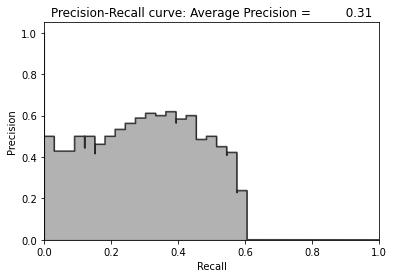

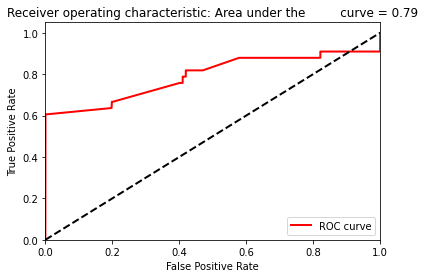

In [18]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

precision vs recall curve is shown from plotresults function

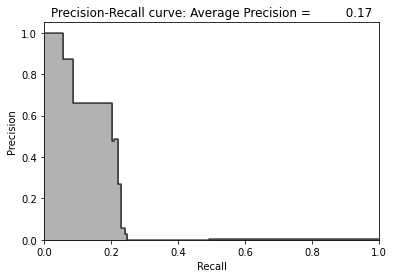

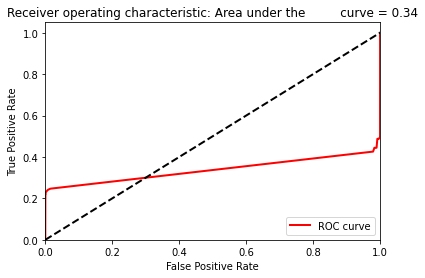

In [19]:

predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

we calculate the precision using precision analysis function

In [20]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.0013093742681343013


we keep oversample multipier as 100 and try to sample the data

In [21]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

we create a sequential neural net model and add some structure to our neural net. mixed with dropouts and dense layers

In [22]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

compile the model with adam optimizer and loss calculated using mean squared error, and for metrics, we pass accuracy

In [23]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

determine the number of epochs and batch size for our model, and then we fit the model using training data.

In [24]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0829 - accuracy: 0.8607 - val_loss: 0.0075 - val_accuracy: 0.9861
Epoch 2/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0185 - accuracy: 0.9269 - val_loss: 0.0104 - val_accuracy: 0.9792
Epoch 3/5
4846/4846 [==============================] - 14s 3ms/step - loss: 0.0175 - accuracy: 0.9272 - val_loss: 0.0458 - val_accuracy: 0.9730
Epoch 4/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0178 - accuracy: 0.9265 - val_loss: 0.0249 - val_accuracy: 0.9767
Epoch 5/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0172 - accuracy: 0.9273 - val_loss: 0.0329 - val_accuracy: 0.9778


again we use plot results and anomaly scores functions to develop charts

5954/5954 [==============================] - 5s 896us/step


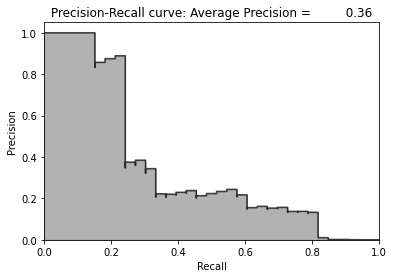

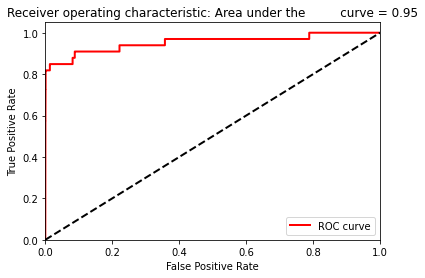

In [25]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

we predict the predictions for test data. and then we calculate average precision for all our predictions.

2938/2938 [==============================] - 3s 876us/step


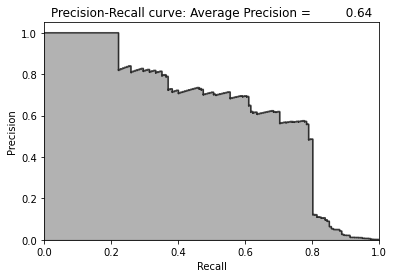

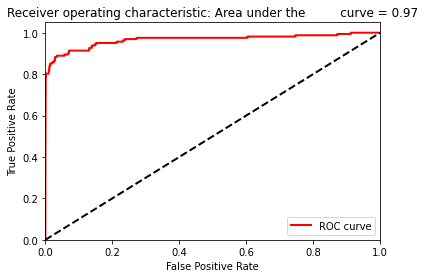

In [26]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

the precision for 75% recall is calculated below

In [27]:

preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.5720930232558139


now lets try to add an intermediate layer. 

In [28]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

intermediate_output_train = intermediate_layer_model.predict(X_train_original)

intermediate_output_test = intermediate_layer_model.predict(X_test_original)

we prepare intermediate dataframes.


In [29]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)

intermediate_output_testDF = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

we then combine the new intermediate dataframe with original training data, the same thing can be said for test dataset. But we don't modify the y train dataframe.

In [30]:
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)

X_test = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)

y_train = y_train_original.copy()

we now train the model based on previous dataframes that we merged and we calculate loses while training our light gb model.

In [31]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00348246
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00332177
[3]	valid_0's binary_logloss: 0.00287131
[4]	valid_0's binary_logloss: 0.00252987
[5]	valid_0's binary_logloss: 0.00251304
[6]	valid_0's binary_logloss: 0.00249738
[7]	valid_0's binary_logloss: 0.0024828
[8]	valid_0's binary_logloss: 0.00246906
[9]	valid_0's binary_logloss: 0.00245613
[10]	valid_0's binary_logloss: 0.00244443
[11]	valid_0's binary_logloss: 0.00243331
[12]	valid_0's binary_logloss: 0.0024227
[13]	valid_0's binary_logloss: 0.00241259
[14]	valid_0's binary_logloss: 0.00240015
[15]	valid_0's binary_logloss: 0.00238956
[16]	valid_0's binary_logloss: 0.0023799
[17]	valid_0's binary_logloss: 0.00237065
[18]	valid_0's binary_logloss: 0.00236181
[19]	valid_0's binary_logloss: 0.00234856
[20]	valid_0's binary_logloss: 0.00234044
[21]	valid_0's binary_logloss: 0.00233265
[22]	valid_0's binary_logloss: 0.00232113
[23]	valid_0's binary_log

the results from lightgb model we trained in previous cell is shown below using plotresults function.


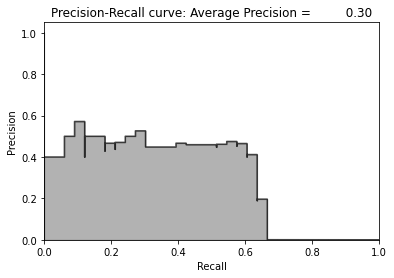

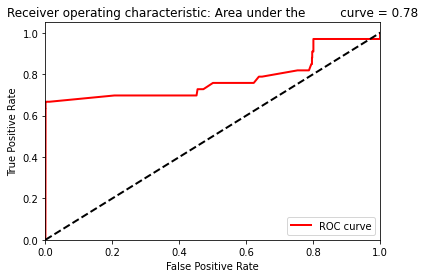

In [32]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

we use the model we trained to give out predictions for our test dataset.

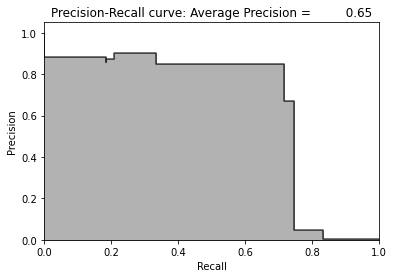

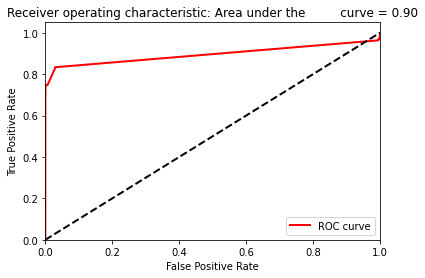

In [33]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)

preds, average_precision = plotResults(y_test, predictions, True)

the precision at 0.75 recall here is calculated below using precision analysis function

In [34]:

preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.10846560846560846


let us calculate the feature importance scores for all the features.

In [35]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])

featuresImportance = featuresImportance/featuresImportance.sum()

featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)

featuresImportance

,featImportance
V1,0.227273
V9,0.090909
24,0.090909
20,0.090909
5,0.090909
...,...
4,0.000000
V2,0.000000
6,0.000000
7,0.000000
